# OpenEO Platform - Atmoshperic Correction Example

### The following notebook will demonstrate the capabilities of OpenEO Platform using the Python Client and the iPyleaflet widget.
We will perform the following tasks:
1. Load a data collection containing Sentinel-2 L1C data. For more info about this type of data, please check [ESA (European Space Agency) official page](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types/level-1c ) or [Sentinelhub webpage](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/)
2. Visualize the retrieved data using different tools
3. Apply the Atmospheric Correction process
4. Compare a the results of two different amospheric correctiion processes

In [1]:
# Import necessary libraries
import time
import rasterio
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import openeo
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polygon, Rectangle,
    GeoJSON,
    DrawControl
)
from traitlets import link
import shapely.geometry

## Run the next cell and select the Area Of Interest using the rectangle button.
### The bounding box coordinates will be passed to openEO later.

In [2]:
center = [ 51.291835566, 3.758216409030558]
zoom = 11
m = Map(center=center, zoom=zoom)
feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

draw = DrawControl(
    circlemarker={}, polyline={}, polygon={}, marker={}, # disable line/circle/rectangle edits
    
    rectangle = {"shapeOptions": {
               "original": {},  # work around for bug in Leaflet.Draw
               "editing": {},   # work around for bug in Leaflet.Draw
    }})

m.add_control(draw)

def handle_draw(target, action, geo_json):
    """Do something with the GeoJSON when it's drawn on the map"""    
    feature_collection['features'].append(geo_json)

draw.on_draw(handle_draw)
m

Map(center=[51.291835566, 3.758216409030558], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [3]:
# We axtract the rectangle cordinates
coords = feature_collection['features'][0]['geometry']['coordinates'][0]
polygon = shapely.geometry.Polygon(coords)
bbox = polygon.bounds

## Connection with openEO back-end and load collection
In the next cell, we will perform a query to the VITO openEO back-end, requesting the data covering the selected area, at a specific date.

In [4]:
#connect with VITO backend
connection = openeo.connect("https://openeo-dev.vito.be").authenticate_basic('guest','guest123')

l1c = connection.load_collection("SENTINEL2_L1C_SENTINELHUB",
            spatial_extent={'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'},
            temporal_extent=["2019-06-23","2019-06-23"],bands=['B04','B03','B02','B09','B8A','B11','CLM','sunAzimuthAngles','sunZenithAngles','viewAzimuthMean','viewZenithMean'] )
# connection.describe_collection("SENTINEL2_L2A_SENTINELHUB")

## Let's have a look at the selected data
1. Download the selected data
2. Load it using the python library rasterio
3. Apply a tone mapping and visualize using Matplotlib
4. Write a png using OpenCV
5. Visualize the data on the map

### 1. Download the selected data

In [5]:
l1c.download("./openeo-rgb-l1c_new.geotiff", format="GTiff")

### 2. Load it using the python library rasterio

In [6]:
src = rasterio.open('./openeo-rgb-l1c_new.geotiff')
l1c_image = src.read()
print('The image has shape: ',l1c_image.shape)

The image has shape:  (11, 1422, 2168)


### 3. Apply a tone map for visualization using Matplotlib
The downloaded data contains 11 bands, but we need only the first 3 (red,green,blue) to get a simple visualization of the data.
We alse need to apply a tone mapping function, which converts the satellite values to a more understandable scale.

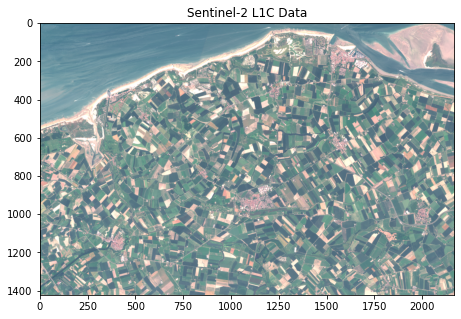

In [7]:
def tone_mapping_matplotlib(image):
    red = image[2] #B04
    green = image[1] #B03
    blue = image[0] #B02
    red = (red+1)/1733*255
    green = (green+1)/1630*255
    blue = (blue+1)/1347*255
    red = np.clip(red,0,255).astype(np.uint8)
    green = np.clip(green,0,255).astype(np.uint8)
    blue = np.clip(blue,0,255).astype(np.uint8)
    bgr = np.zeros((red.shape[0],red.shape[1],3),dtype=np.uint8)
    bgr[:,:,0] = blue
    bgr[:,:,1] = green
    bgr[:,:,2] = red
    return bgr
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Sentinel-2 L1C Data')
ax.imshow((tone_mapping_matplotlib(l1c_image)),cmap='brg', vmin=0, vmax=255)
plt.show()

### 4. Write a png using OpenCV
OpenCV needs the red,green and blue bands in a different order compared to matplotlib and therefore we need to use a different tone mapping function.

In [8]:
def tone_mapping_opencv(image):
    red = image[2] #B04
    green = image[1] #B03
    blue = image[0] #B02
    red = (red+1)/1733*255
    green = (green+1)/1630*255
    blue = (blue+1)/1347*255
    red = np.clip(red,0,255).astype(np.uint8)
    green = np.clip(green,0,255).astype(np.uint8)
    blue = np.clip(blue,0,255).astype(np.uint8)
    bgr = np.zeros((red.shape[0],red.shape[1],3),dtype=np.uint8)
    bgr[:,:,0] = red
    bgr[:,:,1] = green
    bgr[:,:,2] = blue
    return bgr
success = cv2.imwrite('./openeo-rgb-l1c_new.png',tone_mapping_opencv(l1c_image))
if not success:
    print('[!] Failed writing PNG file! Check that the output path exists.')

### 5. Visualize the data on the map

Using the functionality provided by ipyleaflet, we can load the previously written PNG and visualize it on the map in the right spot.

In [9]:
image_overlay = ImageOverlay(
    url="./openeo-rgb-l1c_new.png",
    bounds=((bbox[1], bbox[0]), (bbox[3], bbox[2]))
)

m.add_layer(image_overlay)
m

Map(bottom=174861.0, center=[51.36963708388733, 3.767280840034287], controls=(ZoomControl(options=['position',…

## Apply atmospheric correction
> Satellite images sometimes seem washed out or foggy, as atmosphere absorbs and scatters light on its way to the ground. We can correct for this to get clearer images using atmospheric correction. [Source](https://www.sentinel-hub.com/develop/api/ogc/custom-parameters/atmospheric-correction/)

In [10]:
rgb = l1c.atmospheric_correction()

Download the atmospheric corrected data and visualize it on a new map

In [11]:
download = rgb.download("./openeo-rgb-icor_new.geotiff",format="GTiff")

In [12]:
src_icor = rasterio.open('./openeo-rgb-icor_new.geotiff')
icor_image = src_icor.read()
cv2.imwrite('./openeo-rgb-icor_new.png',tone_mapping_opencv(icor_image))
m2 = Map(center=center, zoom=zoom)
m2
map_center_link = link((m, 'center'), (m2, 'center'))
map_zoom_link = link((m, 'zoom'), (m2, 'zoom'))
image_overlay2 = ImageOverlay(
    url="./openeo-rgb-icor_new.png",
    bounds=((bbox[1], bbox[0]), (bbox[3], bbox[2]))
)

m2.add_layer(image_overlay2)
m2

Map(center=[51.36963708388733, 3.767280840034287], controls=(ZoomControl(options=['position', 'zoom_in_text', …

## Compare the atmospheric corrected data obtained using iCor (openEO) and the available data corrected using Sen2Cor.
### VITO back-end offers a L2A datacube (atmospheric corrected L1C data) produced using a software called Sen2Cor. We can now dowload the same area and get a visual comparison.

In [14]:
rgb_sen2cor = connection.load_collection("SENTINEL2_L2A_SENTINELHUB",
            spatial_extent={'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'},
            temporal_extent=["2019-06-23","2019-06-23"],bands=['B04','B03','B02'] )

download = rgb_sen2cor.download("./openeo-rgb-sen2cor_new.geotiff",format="GTiff")

In [15]:
src_s2cor = rasterio.open('./openeo-rgb-sen2cor_new.geotiff')
s2cor_image = src_s2cor.read()

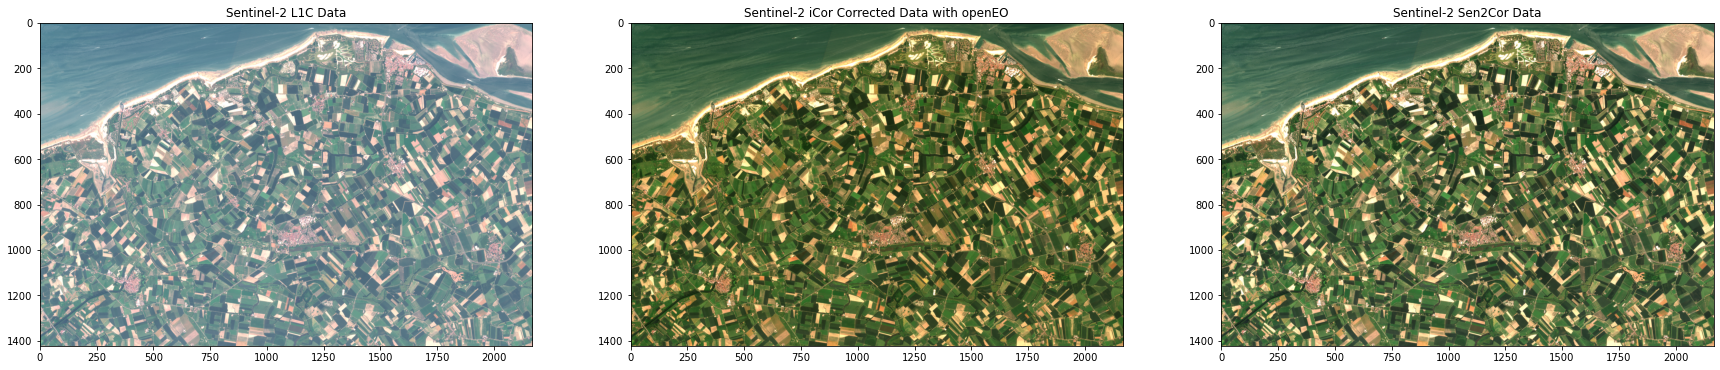

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,30))
ax1.set_title('Sentinel-2 L1C Data')
ax1.imshow((tone_mapping_matplotlib(l1c_image)),cmap='brg', vmin=0, vmax=255)
ax2.set_title('Sentinel-2 iCor Corrected Data with openEO')
ax2.imshow((tone_mapping_matplotlib(icor_image)),cmap='brg', vmin=0, vmax=255)
ax3.set_title('Sentinel-2 Sen2Cor Data')
ax3.imshow((tone_mapping_matplotlib(s2cor_image)),cmap='brg', vmin=0, vmax=255)
plt.show()